### OFELIA: MultiPhysics modelling of a 3D Nuclear Pin
This notebook presents OFELIA, a Python framework for the multi-physics modelling of a 3D nuclear pin. The framework is based on the open-source finite element library dolfinx and OpenMC and is designed to solve the coupled neutronics and thermal-hydraulics problem in a nuclear fuel pin. The notebook demonstrates the use of OFELIA to solve the coupled problem and visualize the results.

In [1]:
import sys
sys.path.append('../')

import os
os.system('rm -r build_xml')

import matplotlib.pyplot as plt
from matplotlib import cm
import gmsh

Let us define some important variables for the simulation:
- Montecarlo Settings
- Geometrical and Physical Parameters

A very important parameter is `n_div` which defines the number of $z-$direction to define the regions to update the temperature in the OpenMC model

In [2]:
import numpy as np

n_div = 8 # Number of axial divisions
Power = 65e3 # W

### MC settings ###
s1_val = 750 # initial particle population
batches = 1000 # number of cycles
inactive = 500
meshSize = 100

tallyDict = {'integral': "Integral Quantities",
             'mesh_xy': "Mesh xy tally",
             'mesh_z': "Mesh z tally",
             'spectrum': "Flux Spectrum"}

### Picard settings ###
maxIter = 20
tol   = 0.01

### Geometrical and physical parameters ###
l_active=366 #  Active length (cm)
L_clad_o = 1.27
total_length = l_active  + 2 * L_clad_o

pin_r = 0.819/2 # Pin radius (cm)
Tin = 273.15 + 290 # K
Tout = Tin + 40
fuel_or = 0.819/2
clad_ir = 0.836/2
clad_or = 0.95/2
pitch = 1.26 # cm
square_side = 1.26 # [pin pitch]
plug_length = 1.27
end_domain_top = 200
end_domain_bot = -200
J_to_eV = 1.602E-19 # J/eV
pin_length = l_active + 2 * plug_length # total length of the pin

### Parameters to compute the bulk T of the coolant and HTC ###
pressure = 155 # bar
T_w_average = Tin + 20 # K # this value actually depends on the power imposed !!!!
u_in = 5.3 * 100 #cm/s

## Create gmsh geometry for *dolfinx*
In this section, the geometry of the fuel pin is created using the Gmsh Python API.

In [3]:
vol_markers = [3000,2000,1000] # markers defining the volumes (fuel, clad, gap)
surf_markers = [100, 200, 300] # marker for the heat transfer surface (coolant_interface, bot, top)

# center_x = 0
# center_y = 0
base_z = -l_active/2

In this cell, the mesh is created using GMSH API (not entering into details).

The `mesh_factor` defines the mesh refinement.

In [4]:
mesh_factor = 0.0015

if os.path.exists("../mesh/cyl3D.msh") == False:

    # Initialize the gmsh module
    gmsh.initialize()

    # Load the .geo file
    gmsh.merge('../mesh/cyl3D.geo')
    gmsh.model.geo.synchronize()

    # Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
    gmsh.option.setNumber("Mesh.Algorithm", 6)

    if mesh_factor is not None:
        gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)

    gmsh.model.mesh.generate(1)
    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.generate(3)

    gmsh.option.setNumber("Mesh.MshFileVersion", 2) #save in ASCII 2 format
    

    # Save the mesh
    gmsh.write("../mesh/cyl3D.msh")
    # gmsh.write("cyl3D.vtk")

else:
    gmsh.initialize()
    gmsh.merge("../mesh/cyl3D.msh")

Info    : Reading '../mesh/cyl3D.msh'...
Info    : 127939 nodes
Info    : 744516 elements                                                                                     


Info    : Done reading '../mesh/cyl3D.msh'                                                                       


Let us create the geometry in *dolfinx* from the gmsh variable

In [5]:
from dolfinx.io import gmshio
from mpi4py import MPI

mesh_comm = MPI.COMM_WORLD
gdim = 3
model_rank = 0 

domain, ct, ft = gmshio.model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )

gmsh.finalize()

## Set up the thermal solver
In this section, the thermal solver is set up. The solver is based on the finite element method (FEM) and uses the `dolfinx` library.

Let us set up the physical parameters for the thermal solver and the boundary conditions

In [6]:
from ofelia.thermal import thermal_inputs, robin_class, thermal_solver, dirichlet_class

th_input = thermal_inputs(T_w_average, pressure)

# The thermal conducticity of the helium gap is increased to consider the radiation HT
physical_param = {'th_cond': np.array([3, 0.25 * 3, 16.23]) / 100.}

T_b_fun = lambda x: Tin + (Tout - Tin)/2*(1+np.sin((x[2])/l_active*np.pi))

bcs =[
      robin_class(marker = surf_markers[0], h = th_input.compute_htc(pitch, clad_or,u_in), Tb = T_b_fun),
      # dirichlet_class(1000, surf_markers[0]),
      # dirichlet_class(Tin, surf_markers[1]),
      # dirichlet_class(Tout, surf_markers[2])
      ]

Let us define the thermal solver with P1 elements


In [7]:
TH = thermal_solver(domain = domain, ct = ct, ft = ft,
                    physical_param = physical_param, regions_markers = vol_markers,
                    degree=1)

The method `apply_BC` applies the boundary conditions to the problem, whereas the method `assemble` assembles the linear system of equations.

In [8]:
TH.applyBCs(bcs)
TH.assemble(direct=False)

The class `norms` is used to compute integrals within dolfinx.

In [9]:
from ofelia.aux_obj import norms

Vnorms = norms(TH.funSpace, domain)

## Setting the OpenMC model
In this section, the OpenMC model is set up. 

The model is implemented in a class in the `build_openmc_model` method and allows to export the `xml` file to be used in OpenMC.

In [10]:
from build_openmc_model import MyOpenMCmodel as OpenMCmodel
import openmc

path_to_run = 'build_xml/it0/'
os.makedirs(path_to_run, exist_ok=True)

# Create the OpenMC model
n_model = OpenMCmodel(path_to_run)

n_model.create_materials(n_div, Tin, Tout)
n_model.create_geometry(fuel_or, clad_ir, clad_or, pitch, l_active, n_div, end_domain_top, end_domain_bot, plug_length)
n_model.create_settings(batches, inactive, s1_val)
n_model.create_tallies(tallyDict, meshSize, square_side, l_active, plug_length)
# n_model.create_plots()

n_model.export_xml_files()

The class `updateXML` is used to update the temperature in the OpenMC model, iteration after iteration.

In [11]:
from ofelia.aux_obj import updateXML

xml_materials = updateXML(n_model.mat_dict, n_div)

## Run the MP simulation
In this section, the multi-physics simulation is run. The simulation consists of a sequence of neutronics and thermal-hydraulics calculations until convergence is reached.

In [12]:
os.system(f"cat ../ofelia/header")
print("\n                   -- Simulation Start --\n")

##################################################################
##                                                              ##
##          OOO   FFFFF  EEEEEE   L      III       A            ##
##         O   O  F      E        L       I       A A           ##
##        O     O F      E        L       I      AAAAA          ##
##        O     O FFFF   EEEEEE   L       I     A     A         ##
##        O     O F      E        L       I     AAAAAAA         ##
##         O   O  F      E        L       I    A       A        ##
##          OOO   F      EEEEEEE  LLLLL  III  A         A       ##
##                                                              ##
##################################################################
##                                                              ##
##           Openmc-FEnicsx for muLtiphysics tutorIAl           ##
##                          -------                             ##
##             ERMETE Lab - Politecnico di Milano             

Let us define the guess temperatues

In [13]:
from dolfinx.fem import Function

Tguess = []
Tguess.append(np.ones((n_div,)) * 300)
Tguess.append(np.ones((n_div,)) * 300)

T_old = Function(TH.funSpace)
T_old.interpolate(lambda x: x[0] * 0. + 300)

The  algorithm for the stationary case is based on a fixed-point iteration: at first, some guess temperatures are provided to start the loop; OpenMC is run and the power density $q'''(z)$ is obtained, which is then used as input to compute the bulk temperature of the fluid by means of the energy balance; lastly, the thermal diffusion is solved using FEniCSx, using the bulk temperature to assign the Robin boundary conditions. These steps are repeated until convergence is reached. The output of each iteration $j>0$ consists of the power density and the temperature field, from which the regional average temperatures $T_{l,(j)}$ are computed. The convergence check is made on the axial power density and temperature as follows
\begin{equation}
\varepsilon_k = \frac{\left\|q'''_{(j)}-q'''_{(j-1)}\right\|_{L^2([-l,l])}}{\left\|q'''_{(j)}\right\|_{L^2([-l,l])}}+ \frac{\left\|T_{(j)}-T_{(j-1)}\right\|_{L^2(\Omega)}}{\left\|T_{(j)}\right\|_{L^2(\Omega)}} <tol
\end{equation}
that is, using the average distance of the power densities in the fuel. By doing so, this algorithm can map any power level into its relative temperature field.

The fixed-point method is typically **conditionally stable**: numerical instabilities may arise when the quantity computed at iteration $j$ is much different from the one at $j-1$; for this reason, we apply an under-relaxation on the the coupling quantity $q'''$, namely:
\begin{equation}
    q'''_{(j)}=\alpha\, q'''_{new}+(1-\alpha)\,q'''_{(j-1)}
\end{equation}
in which $\alpha$ is called under-relaxation factor and $q'''_{new}$ is the output of OpenMC. The former parameter should be usually tuned, increasing the computational cost of the simulation. Classical fixed-point method takes $\alpha$ as a constant quantity over the loop, however, in order to avoid a calibration procedure, the stochastic approximation algorithm can be used to take care of the choice of the under-relaxation factor and the number of neutron histories per iteration at each iteration. 

This method is conceived to minimise the calculation time, by choosing an optimal value for the number of neutron histories $s_j$ at iteration $j$. Given $\alpha_j$ as the under-relaxation factor at iteration $j$, this quantity should be proportional to the statistical error involved in the Monte Carlo simulation, i.e.
\begin{equation}
    \alpha_j \sim \left({\sum_{n=0}^js_j}\,\right)^{-1/2}
\end{equation}
The algorithm prescribes the values for $\alpha_j$ and $s_j$ at each iteration $j$, given an initial value $s_0$
\begin{equation}
    \left\{
        \begin{array}{l}
            s_j = \frac{1}{2}\,\left(s_0+\sqrt{s_0^2+4s_0\cdot \sum_{n=0}^{j-1}s_n}\right)\\ \, \\
            \displaystyle \alpha_j = \frac{s_j}{\sum_{n=0}^js_n}
        \end{array}
    \right.
\end{equation}

In [14]:
error = 10*tol # initial error
alpha = 1 # under-relaxation factor

s1 = s1_val # initial particle population
sum_s = s1  # cumulative sum of particles

The class `extract_power` is used to extract the power from the OpenMC simulation and convert it to a readable format for dolfinx.

In [15]:
from ofelia.aux_obj import extract_power

ExtractPower = extract_power(n_div, Power, meshSize, pin_length, pin_r, J_to_eV, tallyDict)

Slices are created to impose the temperature to the OpenMC materials

In [16]:
slices = np.linspace(base_z, base_z + l_active, n_div+1)

Initialize variables and folders for results

In [17]:
q3_relaxed_list = []
q3_std_list = []

alpha_list = [] # under-relaxation factor
pop_list = []  # population size
errors = {
    'q3': [],
    'T': []
}

from ofelia.aux_obj import RemoveFolders
RemoveFolders(path=os.getcwd())

path = os.getcwd()

Here the Picard loop is implemented

In [18]:
from ofelia.picard import PicardSteps

picard = PicardSteps(path, maxIter, tol, batches, s1)

while error > tol:
    print(f"Iteration {picard.iter}")

    # Run OpenMC
    sp = picard.run_openmc(threads = 15)

    # Get the axial power density from the iteration
    q3_unrelaxed, z, q3std, A = ExtractPower.eval_from_fission(sp, picard.iter)
    q3_integral = np.trapz(q3_unrelaxed, z)
    uq3_integral = np.trapz(q3std, z)
    
    # Relax the power density
    sn, sum_s, q3_relaxed, alpha = picard.under_relaxation(sum_s, q3_unrelaxed, q3_relaxed_list)

    pop_list.append(sn)
    alpha_list.append(alpha)

    q3_relaxed_list.append(q3_relaxed)
    q3_std_list.append(q3std)

    #Print the k value at the iteration
    k_eff = sp.keff
    keff = k_eff.n
    ukeff = k_eff.std_dev
    print('  |-keff: {:.6f}'.format(keff) + ' +- {:.6f}'.format(ukeff))

    print('  Running FEniCSx')
    power_fun_fuel, Tb_fun, res_bulk = th_input.mapping_q3_Tb_1D(z, q3_relaxed, Tin, total_length, l_active, fuel_or)
    power_fun_gap  = th_input.mapping_q3(z, q3_relaxed*0,total_length,l_active) # No power in the gap
    power_fun_clad = th_input.mapping_q3(z, q3_relaxed*0,total_length,l_active) # No power in the clad
    
    # Update BCs
    bcs[0].Tb = Tb_fun
    TH.applyBCs(bcs)

    # Solve the thermal system
    T_sol, q_sol = TH.solve([power_fun_fuel,power_fun_gap,power_fun_clad], power_integral = Power)

    # Computing regional average temperature
    average_T = []
    average_T.append(TH.computeSolidAverageT_Z(vol_markers[0], T_sol, slices))

    dimz_full = z.shape[0]
    if z.shape[0] < 100:
        dimz_full = 100
    else:
        dimz_full = z.shape[0]+100
    average_T.append(th_input.computeWaterAverageT(slices, dimz_full))

    # Compute Errors
    if picard.iter > 0:
        errors_q3 = np.sqrt(np.trapz( (q3_relaxed - q3_relaxed_list[-2])**2, z) / np.trapz( (q3_relaxed)**2, z))
    else:
        errors_q3 = 1
    error_T = Vnorms.L2norm(T_sol - T_old) / Vnorms.L2norm(T_old)
    errors['q3'].append(errors_q3)
    errors['T'].append(error_T)
    error = errors_q3 + error_T

    # Update temperature
    T_old.x.array[:] = T_sol.x.array
    Tguess = average_T.copy()
    
    # Update iteration
    picard.iter += 1

    # Print errors and check convergence
    print('  ')
    if picard.iter > 0:
        print('  Errors: power density = {:.6f}'.format(errors_q3) + ' - temperature = {:.6f}'.format(error_T))
        print('  ')

    if error > tol:
        xml_materials.update(Tguess[0], Tguess[1], sn, picard.iter) # Qui va generalizzato al numero di materiali da updatare
    else:
        print('Convergence reached!')

    if picard.iter >= maxIter:
        error = 0
        print(' ')
        print('###############################################################')
        print(' ')
        print('Warning: Maximum Number of iteration reached!')



Iteration 0
  Running OpenMC
  |-keff: 1.381361 +- 0.001513
  Running FEniCSx
  
  Errors: power density = 1.000000 - temperature = 1.986646
  
Iteration 1
  Running OpenMC
  |-keff: 1.359745 +- 0.001225
  Running FEniCSx
  
  Errors: power density = 0.239743 - temperature = 0.096110
  
Iteration 2
  Running OpenMC
  |-keff: 1.356038 +- 0.001013
  Running FEniCSx
  
  Errors: power density = 0.065227 - temperature = 0.026238
  
Iteration 3
  Running OpenMC
  |-keff: 1.357480 +- 0.000967
  Running FEniCSx
  
  Errors: power density = 0.066526 - temperature = 0.026560
  
Iteration 4
  Running OpenMC
  |-keff: 1.357111 +- 0.000897
  Running FEniCSx
  
  Errors: power density = 0.011799 - temperature = 0.004656
  
Iteration 5
  Running OpenMC
  |-keff: 1.357349 +- 0.000834
  Running FEniCSx
  
  Errors: power density = 0.025883 - temperature = 0.010287
  
Iteration 6
  Running OpenMC
  |-keff: 1.357978 +- 0.000718
  Running FEniCSx
  
  Errors: power density = 0.011297 - temperature = 0.00

Before post-processing the results let us analyse the Picard Parameters for under-relaxation and number of neutron histories.

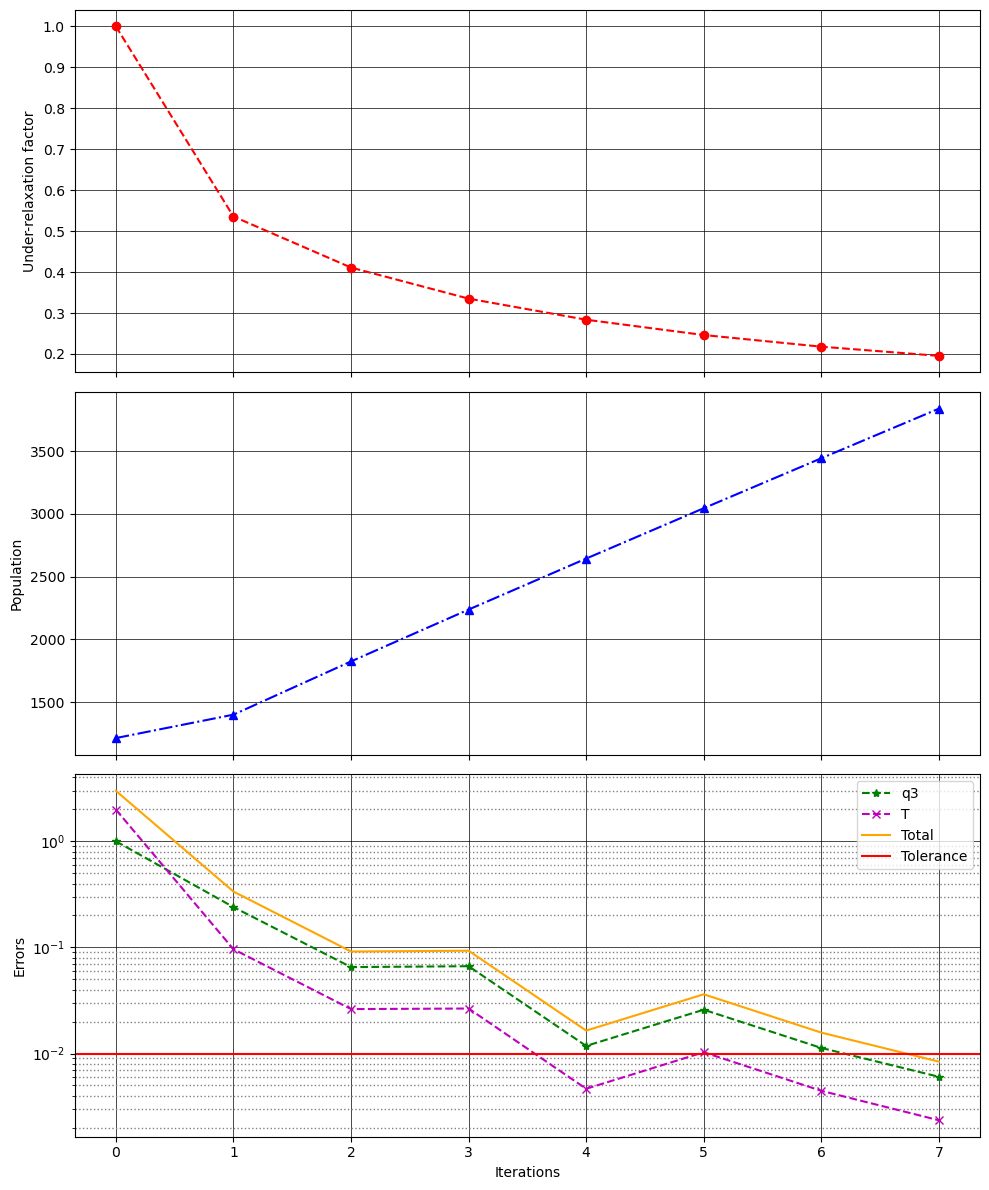

In [19]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

axs[0].plot(alpha_list, 'ro--')
axs[1].plot(pop_list, 'b^-.')

axs[2].semilogy(errors['q3'], 'g*--', label='q3')
axs[2].plot(errors['T'], 'mx--', label='T')
axs[2].plot(np.array(errors['q3']) + np.array(errors['T']), '-', color='orange', label='Total')
axs[2].axhline(tol, color='r', linestyle='-', label='Tolerance')

for ax in axs:
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='1', color='gray')
axs[-1].set_xlabel('Iterations')
axs[-1].legend()

axs[0].set_ylabel('Under-relaxation factor')
axs[1].set_ylabel('Population')
axs[2].set_ylabel('Errors')

plt.tight_layout()

## Post processing
In this section, the results of the simulation are post-processed. The results consist of the temperature field and the power density distribution in the fuel pin.

At first, the benchmark data from [Castagna et al. (2020)](https://link.springer.com/article/10.1140/epjp/s13360-020-00427-3), in which a coupling between Serpent and OpenFOAM is used for the same test case.

In [20]:
benchmark_path = '../BenchmarkData/'

#VERIFICATION DATA
import pandas as pd

castagna_res = dict()

df = pd.read_csv(benchmark_path+'castagna_fuel_temperature.csv')
castagna_res['fuel_temp'] = df.to_numpy()

df = pd.read_csv(benchmark_path+'castagna_coolant_temperature.csv')
castagna_res['coolant_temp'] = df.to_numpy()

df = pd.read_csv(benchmark_path+'castagna_fission_rate_density.csv')
castagna_res['fission_rate'] = df.to_numpy()

Let us compute the averages of the temperature field for the latest iteration, both using `n_div` used in OpenMC and a fine slicing

In [21]:
# Computing regional average temperature
average_T = []
average_T.append(TH.computeSolidAverageT_Z(vol_markers[0], T_sol, slices))
average_T.append(th_input.computeWaterAverageT(slices, z.shape[0]))

# fine slices
fine_slices = np.linspace(base_z, base_z + l_active, 100)
fine_ave_T = []
fine_ave_T.append(TH.computeSolidAverageT_Z(vol_markers[0], T_sol, fine_slices))
fine_ave_T.append(th_input.computeWaterAverageT(fine_slices, z.shape[0]))

Let's plot the averages

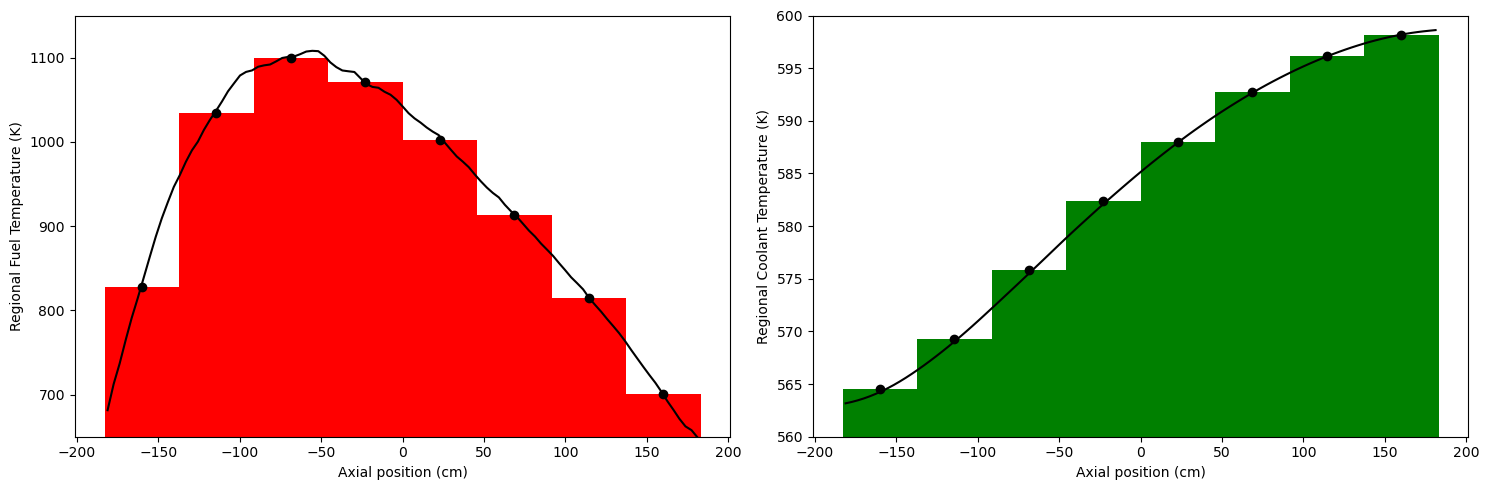

In [22]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(15, 5))

mid_points = (slices[:-1] + slices[1:]) / 2
fine_mid_points = (fine_slices[:-1] + fine_slices[1:]) / 2

axs[0].bar(mid_points, average_T[0], color='r', width=slices[1] - slices[0], edgecolor='none', label='FEniCSx')
axs[0].scatter(mid_points, average_T[0], color='k', label='FEniCSx')
axs[0].plot(fine_mid_points, fine_ave_T[0], 'k-', label='FEniCSx fine')
axs[0].set_ylim(650,1150)
axs[0].set_ylabel('Regional Fuel Temperature (K)')

axs[1].bar(mid_points, average_T[1], color='g', width=slices[1] - slices[0], edgecolor='none', label='FEniCSx')
axs[1].scatter(mid_points, average_T[1], color='k', label='FEniCSx')
axs[1].plot(fine_mid_points, fine_ave_T[1], 'k', label='FEniCSx fine')
axs[1].set_ylim(560,600)
axs[1].set_ylabel('Regional Coolant Temperature (K)')

for ax in axs:
    ax.set_xlabel('Axial position (cm)')

plt.tight_layout()

Let us compare the axial quantities with the benchmark data

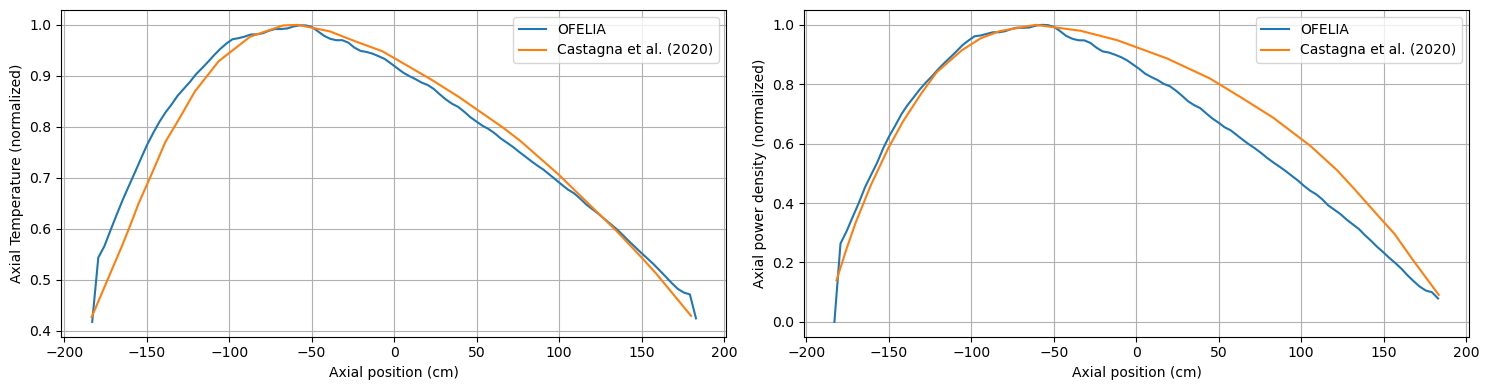

In [24]:
from ofelia.aux_obj import dataOverLine

zz = np.zeros((3,100))
zz[2] = np.linspace(slices[0],slices[-1],100)
extracted_line = dataOverLine(domain = domain, points = zz)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].plot(zz[2], T_sol.eval(*extracted_line) / T_sol.x.array.max(), label='OFELIA')
axs[0].plot(castagna_res['fuel_temp'][:,0]-l_active/2, castagna_res['fuel_temp'][:,1] / max(castagna_res['fuel_temp'][:,1]), label='Castagna et al. (2020)')

axs[1].plot(zz[2], q_sol.eval(*extracted_line) / np.max(q_sol.eval(*extracted_line)), label='OFELIA')
axs[1].plot(castagna_res['fission_rate'][:,0]-l_active/2,castagna_res['fission_rate'][:,1]/np.max(castagna_res['fission_rate'][:,1]), label='Castagna et al. (2020)')

for ax in axs:
    ax.grid()
    ax.set_xlabel('Axial position (cm)')
    ax.legend()

axs[0].set_ylabel('Axial Temperature (normalized)')
axs[1].set_ylabel('Axial power density (normalized)')

plt.tight_layout()

Let us make some contour plot, `grids` extract the cells and the point values for `pyvista`.

In [31]:
import importlib
import vtk
import pyvista

importlib.reload(vtk)
importlib.reload(pyvista)

<module 'pyvista' from '/home/paolo/miniconda3/envs/ofelia/lib/python3.10/site-packages/pyvista/__init__.py'>

In [32]:
import vtk
import pyvista as pv
import dolfinx

# If run on ssh 
pv.start_xvfb()

def grids(fun: dolfinx.fem.Function, varname='u', log_plot: bool = False, 
          mag_plot: bool = True, **kwargs):
    """
    Creates a PyVista grid from a dolfinx.fem.Function and returns the warped or glyph representation.
    
    Parameters
    ----------
    fun : `dolfinx.fem.Function` 
        The function representing the field to be visualized.
    varname : str
        The name to assign to the data in the PyVista grid (default is 'u').
    log_plot : bool
        If True, apply a logarithmic plot to scalar data (default is False).
    mag_plot : bool
        If True, creates a vector warp of the grid. If False, uses glyphs (default is True).
    **kwargs
        Additional keyword arguments passed to the function.
    
    Returns
    ----------
    grid : `pyvista.UnstructuredGrid`
        The resulting PyVista grid, which can be visualized using PyVista plotting functions.
    
    """
    
    # Create a VTK mesh from the function's function space
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    grid = pv.UnstructuredGrid(topology, cells, geometry)
    
    # Handle vector fields (multiple subspaces)
    if fun.function_space.num_sub_spaces > 0:
        # Initialize the values array with zeros and assign the real part of the function's array
        values = np.zeros((geometry.shape[0], 3))
        values[:, :len(fun)] = np.real(fun.x.array.reshape(geometry.shape[0], len(fun)))
        grid[varname] = values

        # Choose between warping by vector or using glyphs
        if mag_plot:
            kwargs.pop('factor', None)  # Remove 'factor' if present, do nothing if not
            kwargs.pop('tolerance', None)  # Remove 'tolerance' if present, do nothing if not
            warped = grid.warp_by_vector(varname, factor=0, **kwargs)  # Apply `kwargs`
        else:
            warped = grid.glyph(varname, **kwargs)  # Apply `kwargs`
        
        return warped, values
    
    # Handle scalar fields (single subspace)
    else:
        if log_plot:
            values = np.log10(np.real(fun.x.array[:]))    
        else:
            values = np.real(fun.x.array[:])
            
        grid.point_data[varname] = values
        grid.set_active_scalars(varname)
        
        return grid, values.reshape(-1,1)


Here the temperature is plotted

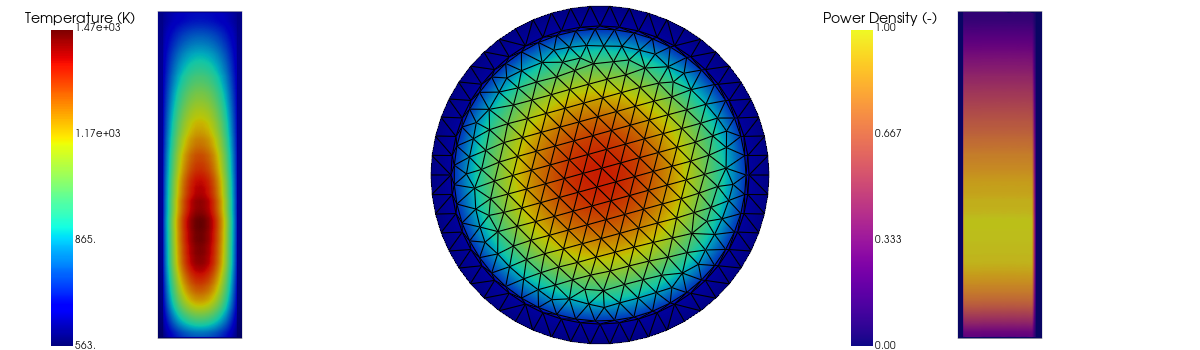

In [36]:
T_grid = grids(T_sol, varname='T', log_plot=False, mag_plot=False)[0]

from dolfinx.fem import Function, Expression
Q_funP1 = Function(TH.funSpace)
Q_funP1.interpolate(Expression(q_sol, TH.funSpace.element.interpolation_points()))
Q_funP1.x.array[:] = Q_funP1.x.array[:] / np.max(Q_funP1.x.array)
q_grid = grids(Q_funP1, varname='q', log_plot=False, mag_plot=False)[0]

clim = [[min(T_sol.x.array), max(T_sol.x.array)], [min(Q_funP1.x.array), max(Q_funP1.x.array)]]
cmaps = [cm.jet, cm.plasma]

nrows = 1
ncols = 3
resolution = [400 * ncols, 350 * nrows]
pl = pv.Plotter(shape=(nrows, ncols), border=False, window_size=resolution)
    
# Dictionary for the colorbar
dict_cb = dict( title='Temperature (K)',
                width = 0.15, height = 0.95,
                title_font_size=14,
                label_font_size=10,
                n_labels=4,
                color = 'k',
                position_x=0.125, position_y=0.0,
                shadow=False,
                vertical=True) 

pl.subplot(0, 0)

# Scale in the z-direction
matrix_transf = np.eye(4)
matrix_transf[2, 2] = 0.01

pl.add_mesh(T_grid.slice(normal='y').transform(matrix_transf), scalars='T', cmap=cmaps[0], clim=clim[0], scalar_bar_args=dict_cb)
pl.view_xz()

pl.subplot(0, 1)
pl.add_mesh(T_grid.slice(normal='z'), scalars='T', cmap=cmaps[0], clim=clim[0], show_edges=True, scalar_bar_args=dict_cb)
pl.view_xy()
pl.zoom_camera(1.4)

pl.subplot(0, 2)
dict_cb['title'] = 'Power Density (-)'
pl.add_mesh(q_grid.slice(normal='y').transform(matrix_transf), scalars='q', cmap=cmaps[1], clim=clim[1], show_edges=False, scalar_bar_args=dict_cb)
pl.view_xz()

pl.show(jupyter_backend='static')
